# Import

In [1]:
import pandas as pd
import numpy as np
import csv
import lightgbm as lgb
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score,
                             matthews_corrcoef)
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Dataset Class

In [2]:
class EMGDatasetPreparer:
    """Handles dataset loading, filtering and splitting with balance constraints"""
    
    def __init__(self, csv_path: str):
        self.df = pd.read_csv(csv_path, sep=';', decimal=',')
        self._validate_dataset()
    
    def _validate_dataset(self):
        """Verify dataset structure"""
        required_cols = ['File Name', 'Muscle Name', 'Condition']
        for col in required_cols:
            if col not in self.df.columns:
                raise ValueError(f"Missing required column: {col}")
        
        # Check class distribution
        # print("\n=== Dataset Overview ===")
        # print(f"Total samples: {len(self.df)}")
        for condition in ['Healthy', 'Neuropathy']:
            for muscle in ['Deltoid', 'Biceps']:
                count = len(self.df[(self.df['Condition'] == condition) & 
                                   (self.df['Muscle Name'] == muscle)])
                # print(f"{condition} {muscle}: {count}")
    
    def prepare_dataset(self, 
                       feature_names: List[str],
                       muscle_filter: str = 'Both',
                       test_size: float = 0.2,
                       balance_muscles: bool = True,
                       random_seed: int = 42) -> Tuple[np.ndarray, np.ndarray, 
                                                        np.ndarray, np.ndarray]:
        """
        Prepare and split dataset with balance constraints
        
        Args:
            feature_names: List of feature names to include
            muscle_filter: 'Deltoid', 'Biceps', or 'Both'
            test_size: Proportion of data for test set (0-1)
            balance_muscles: If True, ensure 50/50 Deltoid/Biceps in each class
            random_seed: Random seed for reproducibility
        
        Returns:
            X_train, X_test, y_train, y_test
        """
        np.random.seed(random_seed)
        
        # Filter by muscle type
        if muscle_filter in ['Deltoid', 'Biceps']:
            df_filtered = self.df[self.df['Muscle Name'] == muscle_filter].copy()
            # print(f"\n=== Using only {muscle_filter} samples ===")
        else:
            df_filtered = self.df.copy()
            # print("\n=== Using Both Deltoid and Biceps ===")
        
        # Extract features and labels
        X = df_filtered[feature_names].values
        y = (df_filtered['Condition'] == 'Neuropathy').astype(int).values
        muscle_type = df_filtered['Muscle Name'].values
        
        # Split with balance constraints
        if balance_muscles and muscle_filter == 'Both':
            X_train, X_test, y_train, y_test = self._balanced_split(
                X, y, muscle_type, test_size, random_seed)
        else:
            X_train, X_test, y_train, y_test = self._simple_balanced_split(
                X, y, test_size, random_seed)
        
        # print(f"\nTraining set: {len(y_train)} samples")
        # print(f"  Healthy: {(y_train == 0).sum()}, Neuropathy: {(y_train == 1).sum()}")
        # print(f"Test set: {len(y_test)} samples")
        # print(f"  Healthy: {(y_test == 0).sum()}, Neuropathy: {(y_test == 1).sum()}")
        
        return X_train, X_test, y_train, y_test
    
    def _balanced_split(self, X, y, muscle_type, test_size, seed):
        """Split ensuring 50/50 muscle balance within each class"""
        np.random.seed(seed)
        
        # Separate by class and muscle
        healthy_deltoid = (y == 0) & (muscle_type == 'Deltoid')
        healthy_biceps = (y == 0) & (muscle_type == 'Biceps')
        neuro_deltoid = (y == 1) & (muscle_type == 'Deltoid')
        neuro_biceps = (y == 1) & (muscle_type == 'Biceps')
        
        # Calculate test samples per group (ensure even split)
        n_test_per_group = int(len(X) * test_size / 4)
        
        # Randomly select test indices from each group
        test_idx = np.concatenate([
            np.random.choice(np.where(healthy_deltoid)[0], n_test_per_group, False),
            np.random.choice(np.where(healthy_biceps)[0], n_test_per_group, False),
            np.random.choice(np.where(neuro_deltoid)[0], n_test_per_group, False),
            np.random.choice(np.where(neuro_biceps)[0], n_test_per_group, False)
        ])
        
        train_idx = np.setdiff1d(np.arange(len(X)), test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
    def _simple_balanced_split(self, X, y, test_size, seed):
        """Split ensuring class balance only"""
        np.random.seed(seed)
        
        healthy_idx = np.where(y == 0)[0]
        neuro_idx = np.where(y == 1)[0]
        
        n_test_healthy = int(len(healthy_idx) * test_size)
        n_test_neuro = int(len(neuro_idx) * test_size)
        
        test_healthy = np.random.choice(healthy_idx, n_test_healthy, False)
        test_neuro = np.random.choice(neuro_idx, n_test_neuro, False)
        
        test_idx = np.concatenate([test_healthy, test_neuro])
        train_idx = np.setdiff1d(np.arange(len(X)), test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# LightGBM Cross Validation Class

In [3]:
class LGBMClassifierCV:
    """LightGBM classifier with cross-validation and customizable probability threshold"""
    
    def __init__(self, n_folds: int = 5, random_seed: int = 42, threshold: float = 0.5):
        self.n_folds = n_folds
        self.random_seed = random_seed
        self.threshold = threshold
        self.best_params = None
        self.best_model = None
        self.cv_results = None
        self.best_num_iterations = None  # Memorizza il numero ottimale di iterazioni
    
    def set_threshold(self, threshold: float):
        """Cambia la soglia di classificazione"""
        if not 0 <= threshold <= 1:
            raise ValueError("Threshold must be between 0 and 1")
        self.threshold = threshold
    
    def cross_validate(self, 
                       X_train: np.ndarray, 
                       y_train: np.ndarray,
                       params: Dict,
                       threshold: float = None) -> Dict:
        """
        Perform k-fold cross-validation
        
        Args:
            threshold: Optional threshold override for this CV run
        
        Returns:
            Dictionary with mean and std of all metrics, including num_iterations
        """
        thresh = threshold if threshold is not None else self.threshold
        
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, 
                              random_state=self.random_seed)
        
        metrics = {
            'accuracy': [], 'sensitivity': [], 'specificity': [],
            'f1': [], 'auc': [], 'mcc': [], 
            'confusion_matrices': [],
            'num_iterations': []  # Traccia il numero di iterazioni per fold
        }
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            train_data = lgb.Dataset(X_tr, label=y_tr)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False),
                          lgb.log_evaluation(period=0)]
            )
            
            # Salva il numero di iterazioni utilizzate
            metrics['num_iterations'].append(model.best_iteration)
            
            y_pred_proba = model.predict(X_val)
            y_pred = (y_pred_proba >= thresh).astype(int)
            
            cm = confusion_matrix(y_val, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            metrics['accuracy'].append(accuracy_score(y_val, y_pred))
            metrics['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
            metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            metrics['f1'].append(f1_score(y_val, y_pred))
            metrics['auc'].append(roc_auc_score(y_val, y_pred_proba))
            metrics['mcc'].append(matthews_corrcoef(y_val, y_pred))
            metrics['confusion_matrices'].append(cm)
        
        results = {
            'threshold': thresh,
            'accuracy_mean': np.mean(metrics['accuracy']),
            'accuracy_std': np.std(metrics['accuracy']),
            'sensitivity_mean': np.mean(metrics['sensitivity']),
            'sensitivity_std': np.std(metrics['sensitivity']),
            'specificity_mean': np.mean(metrics['specificity']),
            'specificity_std': np.std(metrics['specificity']),
            'f1_mean': np.mean(metrics['f1']),
            'f1_std': np.std(metrics['f1']),
            'auc_mean': np.mean(metrics['auc']),
            'auc_std': np.std(metrics['auc']),
            'mcc_mean': np.mean(metrics['mcc']),
            'mcc_std': np.std(metrics['mcc']),
            'confusion_matrices': metrics['confusion_matrices'],
            'num_iterations_mean': np.mean(metrics['num_iterations']),
            'num_iterations_median': np.median(metrics['num_iterations']),
            'num_iterations_std': np.std(metrics['num_iterations']),
            'num_iterations_all': metrics['num_iterations']
        }
        
        return results
    
    def optimize_threshold(self,
                          X_train: np.ndarray,
                          y_train: np.ndarray,
                          metric: str = 'f1',
                          threshold_range: tuple = (0.3, 0.7),
                          n_thresholds: int = 21) -> float:
        """
        Trova la soglia ottimale basandosi su una metrica specifica
        
        Args:
            metric: 'f1', 'mcc', 'accuracy', 'sensitivity', 'specificity'
            threshold_range: Range di soglie da testare
            n_thresholds: Numero di soglie da testare
        
        Returns:
            Best threshold
        """
        if self.best_params is None:
            raise ValueError("Run grid_search first to find best parameters")
        
        thresholds = np.linspace(threshold_range[0], threshold_range[1], n_thresholds)
        results = []
        
        for thresh in thresholds:
            cv_results = self.cross_validate(X_train, y_train, 
                                            self.best_params, threshold=thresh)
            metric_value = cv_results[f'{metric}_mean']
            results.append((thresh, metric_value))
        
        best_thresh, best_value = max(results, key=lambda x: x[1])
        self.threshold = best_thresh
        
        return best_thresh
    
    def grid_search(self,
                   X_train: np.ndarray,
                   y_train: np.ndarray,
                   param_grid: Dict[str, List],
                   threshold: float = None) -> Tuple[Dict, Dict]:
        """
        Perform grid search with cross-validation
        
        Args:
            X_train: Training features
            y_train: Training labels
            param_grid: Dictionary of parameters to search
            threshold: Optional threshold override
        
        Returns:
            best_params, all_results
        """
        from itertools import product
        
        keys = param_grid.keys()
        values = param_grid.values()
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]
        
        thresh = threshold if threshold is not None else self.threshold
        
        all_results = []
        best_score = -1
        best_params = None
        best_cv_results = None
        
        for i, params in enumerate(param_combinations):
            full_params = {
                'objective': 'binary',
                'metric': 'auc',
                'verbosity': -1,
                'seed': self.random_seed,
                **params
            }
            
            cv_results = self.cross_validate(X_train, y_train, full_params, threshold=thresh)
            
            result_entry = {
                'params': params,
                'cv_results': cv_results
            }
            all_results.append(result_entry)
            
            if cv_results['auc_mean'] > best_score:
                best_score = cv_results['auc_mean']
                best_params = full_params
                best_cv_results = cv_results
        
        self.best_params = best_params
        self.cv_results = best_cv_results
        
        # Salva il numero ottimale di iterazioni dalla CV (usa la mediana per robustezza)
        self.best_num_iterations = int(np.ceil(best_cv_results['num_iterations_median']))
        
        return best_params, all_results
    
    def train_final_model(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Train final model on full training set usando il numero di iterazioni
        ottimale trovato durante la cross-validation
        
        Args:
            X_train: Training features
            y_train: Training labels
        """
        if self.best_params is None:
            raise ValueError("Run grid_search first to find best parameters")
        
        if self.best_num_iterations is None:
            raise ValueError("best_num_iterations not set. Run grid_search first.")
        
        train_data = lgb.Dataset(X_train, label=y_train)
        
        # Training con numero fisso di iterazioni dalla CV
        self.best_model = lgb.train(
            self.best_params,
            train_data,
            num_boost_round=self.best_num_iterations
        )
    
    def evaluate_test_set(self, 
                         X_test: np.ndarray, 
                         y_test: np.ndarray,
                         threshold: float = None) -> Dict:
        """
        Evaluate on held-out test set
        
        Args:
            threshold: Optional threshold override
        """
        if self.best_model is None:
            raise ValueError("Train final model first")
        
        thresh = threshold if threshold is not None else self.threshold
        
        y_pred_proba = self.best_model.predict(X_test)
        y_pred = (y_pred_proba >= thresh).astype(int)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        
        results = {
            'threshold': thresh,
            'accuracy': accuracy_score(y_test, y_pred),
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr, thresholds),
            'predictions': y_pred,
            'predictions_proba': y_pred_proba,
            'num_iterations_used': self.best_num_iterations
        }
        
        return results

In [4]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [5]
}

# Main

## Feature Vector

In [5]:
# Configuration

# You can comment the features you don't want to include
feature_names = [
    'Mean Absolute Value',           # 0
    'Root Mean Square',              # 1
    'Zero Crossings',                # 2
    'Peak Frequency',                # 3
    'Mean Frequency',                # 4
    'Median Frequency',              # 5
    'Total Power',                   # 6
    'Variance',                      # 7
    'Shannon Entropy',               # 8
    'Signal Skewness',               # 9
    'Signal Kurtosis',               # 10
    'Petrosian FD',                  # 11
    'Slope Sign Changes',            # 12
    'Waveform Length',               # 13
    'SNR',                           # 14
    'Recurrence',                    # 15
    'Muscle'                         # 16  
]

## Grid Search

In [28]:
custom_threshold = 0.5

# Example usage
if __name__ == "__main__":
    
    # Load and prepare dataset (change the path to de dataset)
    preparer = EMGDatasetPreparer(r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\features_dataset_healthy_vs_neuropathy_8_20_2000_3.csv')
    X_train, X_test, y_train, y_test = preparer.prepare_dataset(
        feature_names=feature_names,
        muscle_filter='Both',      # 'Deltoid', 'Biceps', or 'Both'
        test_size=0.2,
        balance_muscles=True,      # Ensure 50/50 muscle split
        random_seed=42
    )
    
    # Define parameter grid
    param_grid = {
        'learning_rate': [0.05, 0.1, 0.3, 0.4],
        'num_leaves': [15],
        'max_depth': [5, 7],
        'min_data_in_leaf': [10],
        'feature_fraction': [0.8, 0.9, 1.0],
        'bagging_fraction': [0.8, 0.9, 1.0],
        'bagging_freq': [5]
    }
    

    # Initialize classifier and perform grid search
    classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)
    best_params, all_results = classifier.grid_search(X_train, y_train, param_grid)
    
    # Train final model and evaluateuate_test_set(X_test, y_test)
    classifier.train_final_model(X_train, y_train)
    test_results = classifier.evaluate_test_set(X_test, y_test)

## Train and Test on 100 different splits

In [23]:
print(best_params)

param_grid = {
    'learning_rate': [best_params['learning_rate']],
    'num_leaves': [best_params['num_leaves']],
    'max_depth': [best_params['max_depth']],
    'min_data_in_leaf': [best_params['min_data_in_leaf']],
    'feature_fraction': [best_params['feature_fraction']],
    'bagging_fraction': [best_params['bagging_fraction']],
    'bagging_freq': [best_params['bagging_freq']]
}

print(f"learning_rate :    {param_grid['learning_rate'][0]}")
print(f"num_leaves :       {param_grid['num_leaves'][0]}")
print(f"max_depth :        {param_grid['max_depth'][0]}")
print(f"min_data_in_leaf : {param_grid['min_data_in_leaf'][0]}")
print(f"feature_fraction : {param_grid['feature_fraction'][0]}")
print(f"bagging_fraction : {param_grid['bagging_fraction'][0]}")
print(f"bagging_freq :     {param_grid['bagging_freq'][0]}")

{'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'seed': 42, 'learning_rate': 0.4, 'num_leaves': 15, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'bagging_freq': 5}
learning_rate :    0.4
num_leaves :       15
max_depth :        5
min_data_in_leaf : 10
feature_fraction : 1.0
bagging_fraction : 0.9
bagging_freq :     5


In [24]:
# Example usage
if __name__ == "__main__":
    
    accuracy_list = []
    sensitivity_list = []
    specificity_list = []
    f1_list = []
    AUC_list = []
    MCC_list = []

    print(f"{param_grid['learning_rate'][0]},{param_grid['num_leaves'][0]},{param_grid['max_depth'][0]},{param_grid['min_data_in_leaf'][0]},{param_grid['feature_fraction'][0]},{param_grid['bagging_fraction'][0]},{param_grid['bagging_freq'][0]}")
    
    time_list = []

    for rs in range(1,101):

        # Load and prepare dataset
        preparer = EMGDatasetPreparer(r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\features_dataset_healthy_vs_neuropathy_8_20_2000_3.csv')
        X_train, X_test, y_train, y_test = preparer.prepare_dataset(
            feature_names=feature_names,
            muscle_filter='Both',      # 'Deltoid', 'Biceps', or 'Both'
            test_size=0.2,
            balance_muscles=True,      # Ensure 50/50 muscle split
            random_seed=rs
        )
            

        classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)

        best_params, all_results = classifier.grid_search(X_train, y_train, param_grid)

        # Train final model and evaluateuate_test_set(X_test, y_test)
        classifier.train_final_model(X_train, y_train)

        start = time.time()
        test_results = classifier.evaluate_test_set(X_test, y_test)
        eval_time = time.time() - start

        time_list.append(eval_time/40)

        accuracy_list.append(test_results['accuracy'])
        sensitivity_list.append(test_results['sensitivity'])
        specificity_list.append(test_results['specificity'])
        f1_list.append(test_results['f1'])
        AUC_list.append(test_results['auc'])
        MCC_list.append(test_results['mcc'])

        if (rs % 5) == 0:
            print(f"{rs}")
            print(f"accuracy: {np.mean(accuracy_list)} ± {np.std(accuracy_list)}")
            print("\n============================\n")

    # print("\n\n==============================\n==============================")
    # print(f"Accuracy Mean    = {np.mean(accuracy_list):.5f} ± {np.std(accuracy_list):.5f}")
    # print(f"Sensitivity Mean = {np.mean(sensitivity_list):.5f} ± {np.std(sensitivity_list):.5f}")
    # print(f"Specificity Mean = {np.mean(specificity_list):.5f} ± {np.std(specificity_list):.5f}")
    # print(f"f1 Mean         = {np.mean(f1_list):.5f} ± {np.std(f1_list):.5f}")
    # print(f"AUC Mean         = {np.mean(AUC_list):.5f} ± {np.std(AUC_list):.5f}")
    # print(f"MCC Mean         = {np.mean(MCC_list):.5f} ± {np.std(MCC_list):.5f}")

    # print(f"{len(feature_names)},{np.mean(accuracy_list)},{np.std(accuracy_list)},{np.mean(sensitivity_list)},{np.std(sensitivity_list)},{np.mean(specificity_list)},{np.std(specificity_list)},{np.mean(f1_list)},{np.std(f1_list)},{np.mean(AUC_list)},{np.std(AUC_list)},{np.mean(MCC_list)},{np.std(MCC_list)}")
    # print(f"{param_grid['learning_rate'][0]},{param_grid['num_leaves'][0]},{param_grid['max_depth'][0]},{param_grid['min_data_in_leaf'][0]},{param_grid['feature_fraction'][0]},{param_grid['bagging_fraction'][0]},{param_grid['bagging_freq'][0]}")

    # print("==============================\n==============================")

    print(f"time: {np.mean(time_list)} ± {np.std(time_list)}")
    print(f"accuracy: {np.mean(accuracy_list)} ± {np.std(accuracy_list)}")

0.4,15,5,10,1.0,0.9,5
5
accuracy: 0.925 ± 0.03872983346207416


10
accuracy: 0.93 ± 0.033166247903553984


15
accuracy: 0.9283333333333335 ± 0.035197853469904776


20
accuracy: 0.93 ± 0.031224989991991976


25
accuracy: 0.926 ± 0.03277193921634787


30
accuracy: 0.9225 ± 0.03375771516754848


35
accuracy: 0.9214285714285714 ± 0.03440455593940655


40
accuracy: 0.920625 ± 0.03786798614925277


45
accuracy: 0.922222222222222 ± 0.036599264648890226


50
accuracy: 0.9225 ± 0.0375


55
accuracy: 0.9218181818181816 ± 0.036009640582433375


60
accuracy: 0.9195833333333332 ± 0.035966322982602605


65
accuracy: 0.9207692307692308 ± 0.03577956839863917


70
accuracy: 0.9207142857142857 ± 0.03584974311808458


75
accuracy: 0.9196666666666667 ± 0.03565887765417688


80
accuracy: 0.9199999999999999 ± 0.03544361719689456


85
accuracy: 0.9208823529411764 ± 0.03594257241921794


90
accuracy: 0.9197222222222221 ± 0.03772974888091999


95
accuracy: 0.9176315789473684 ± 0.03802244562348844


100
accurac

In [25]:
print(f"{len(feature_names)},{np.mean(accuracy_list)},{np.std(accuracy_list)},{np.mean(sensitivity_list)},{np.std(sensitivity_list)},{np.mean(specificity_list)},{np.std(specificity_list)},{np.mean(f1_list)},{np.std(f1_list)},{np.mean(AUC_list)},{np.std(AUC_list)},{np.mean(MCC_list)},{np.std(MCC_list)}")

17,0.917,0.038223029707232785,0.9024999999999999,0.06378675411086536,0.9315000000000001,0.05131033034389858,0.9152229197488922,0.03997330881492802,0.9593749999999999,0.028260783340169467,0.8374346224033089,0.07546787573843443


# SHAP

In [29]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Optional
import os

class SHAPAnalyzer:
    """SHAP analysis for LightGBM model with modern visualizations"""
    
    def __init__(self, model, X_test: np.ndarray, feature_names: list, 
                 threshold: float = 0.5, output_dir: Optional[str] = None):
        """
        Initialize SHAP analyzer
        
        Args:
            model: Trained LightGBM model
            X_test: Test set features
            feature_names: List of feature names
            threshold: Classification threshold
            output_dir: Directory to save plots (optional, defaults to current directory)
        """
        self.model = model
        self.X_test = X_test
        self.feature_names = feature_names
        self.threshold = threshold
        
        # Setup output directory
        self.output_dir = output_dir if output_dir else os.getcwd()
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        # Create SHAP explainer
        self.explainer = shap.TreeExplainer(self.model)
        self.shap_values = self.explainer.shap_values(X_test)
        self.base_value = self.explainer.expected_value
        
        # Setup modern style
        plt.style.use('seaborn-v0_8-darkgrid')
        self.colors = {
            'positive': '#FF6B6B',  # Coral red for positive impact
            'negative': '#4ECDC4',  # Turquoise for negative impact
            'neutral': '#95A5A6'    # Gray for neutral
        }
    
    def plot_feature_importance(self, max_display: int = 20, figsize: Tuple = (10, 8),
                               save: bool = False, format: str = 'pdf',
                               filename: str = 'shap_feature_importance'):
        """
        Plot mean absolute SHAP values (global feature importance)
        
        Args:
            max_display: Maximum number of features to display
            figsize: Figure size
            save: Whether to save the figure
            format: File format ('pdf', 'svg', 'eps', or 'png')
            filename: Base filename for saving (without extension)
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Calculate mean absolute SHAP values
        mean_abs_shap = np.abs(self.shap_values).mean(axis=0)
        
        # Sort features by importance
        sorted_idx = np.argsort(mean_abs_shap)[::-1][:max_display]
        sorted_features = [self.feature_names[i] for i in sorted_idx]
        sorted_values = mean_abs_shap[sorted_idx]
        
        # Create horizontal bar plot
        y_pos = np.arange(len(sorted_features))
        colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(sorted_features)))
        
        bars = ax.barh(y_pos, sorted_values, color=colors, edgecolor='black', 
                       linewidth=1.2, alpha=0.85)
        
        # Styling - TESTI INGRANDITI
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_features, fontsize=14)
        ax.set_xlabel('Mean |SHAP value|', fontsize=18, fontweight='bold')
        ax.set_title('Global Feature Importance', fontsize=20, fontweight='bold', 
                     pad=20)
        ax.tick_params(axis='x', labelsize=14)
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add value labels on bars - TESTO INGRANDITO
        for i, (bar, val) in enumerate(zip(bars, sorted_values)):
            ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        # Save if requested
        if save:
            output_path = os.path.join(self.output_dir, f'{filename}.{format}')
            fig.savefig(output_path, format=format, bbox_inches='tight', dpi=300)
            print(f"Saved: {output_path}")
        
        plt.show()
        
        return fig
    
    def plot_beeswarm(self, max_display: int = 20, figsize: Tuple = (12, 8),
                     save: bool = False, format: str = 'pdf',
                     filename: str = 'shap_beeswarm'):
        """
        Plot SHAP beeswarm plot showing feature impact on each sample
        
        Args:
            max_display: Maximum number of features to display
            figsize: Figure size
            save: Whether to save the figure
            format: File format ('pdf', 'svg', 'eps', or 'png')
            filename: Base filename for saving (without extension)
        """
        fig = plt.figure(figsize=figsize)
        
        shap.summary_plot(
            self.shap_values, 
            self.X_test,
            feature_names=self.feature_names,
            max_display=max_display,
            plot_type="violin",
            show=False,
            color_bar_label="Feature value"
        )
        
        # TESTI INGRANDITI
        plt.title('SHAP Beeswarm Plot - Feature Impact on Predictions', 
                 fontsize=20, fontweight='bold', pad=20)
        plt.xlabel('SHAP value (impact on model output)', fontsize=18, 
                  fontweight='bold')
        
        # Ingrandire i tick labels
        ax = plt.gca()
        ax.tick_params(axis='both', labelsize=14)
        
        plt.tight_layout()
        
        # Save if requested
        if save:
            output_path = os.path.join(self.output_dir, f'{filename}.{format}')
            fig.savefig(output_path, format=format, bbox_inches='tight', dpi=300)
            print(f"Saved: {output_path}")
        
        plt.show()
        
        return fig
    
    def plot_waterfall_sample(self, sample_idx: int, y_pred: np.ndarray, 
                             y_pred_proba: np.ndarray, file_names: np.ndarray = None,
                             figsize: Tuple = (12, 8), save: bool = False, 
                             format: str = 'pdf', filename: str = None):
        """
        Plot waterfall chart for a specific sample showing decision path
        
        Args:
            sample_idx: Index of sample in test set
            y_pred: Predictions array
            y_pred_proba: Prediction probabilities array
            file_names: Array of file names (optional)
            figsize: Figure size
            save: Whether to save the figure
            format: File format ('pdf', 'svg', 'eps', or 'png')
            filename: Base filename for saving (without extension, auto-generated if None)
        """
        # Get prediction info
        pred_class = y_pred[sample_idx]
        pred_proba = y_pred_proba[sample_idx]
        class_name = "Neuropathy" if pred_class == 1 else "Healthy"
        
        # Print sample info
        print(f"\n{'='*60}")
        print(f"Sample #{sample_idx}")
        if file_names is not None:
            print(f"File: {file_names[sample_idx]}")
        print(f"Predicted: {class_name} (probability: {pred_proba:.4f})")
        print(f"Threshold: {self.threshold:.2f}")
        print(f"{'='*60}\n")
        
        # Create waterfall plot
        fig = plt.figure(figsize=figsize)
        
        shap_explanation = shap.Explanation(
            values=self.shap_values[sample_idx],
            base_values=self.base_value,
            data=self.X_test[sample_idx],
            feature_names=self.feature_names
        )
        
        shap.plots.waterfall(shap_explanation, max_display=15, show=False)
        
        # TESTI INGRANDITI
        plt.title(f'Decision Explanation - {class_name} Sample\n'
                 f'Probability: {pred_proba:.4f} | Threshold: {self.threshold:.2f}',
                 fontsize=20, fontweight='bold', pad=20)
        
        # Ingrandire i tick labels
        ax = plt.gca()
        ax.tick_params(axis='both', labelsize=14)
        
        # Ingrandire le etichette degli assi se presenti
        if ax.get_xlabel():
            ax.set_xlabel(ax.get_xlabel(), fontsize=18, fontweight='bold')
        if ax.get_ylabel():
            ax.set_ylabel(ax.get_ylabel(), fontsize=18, fontweight='bold')
        
        plt.tight_layout()
        
        # Save if requested
        if save:
            if filename is None:
                filename = f'shap_waterfall_sample_{sample_idx}_{class_name.lower()}'
            output_path = os.path.join(self.output_dir, f'{filename}.{format}')
            fig.savefig(output_path, format=format, bbox_inches='tight', dpi=300)
            print(f"Saved: {output_path}")
        
        plt.show()
        
        return fig
    
    def analyze_correctly_classified_samples(self, y_test: np.ndarray, 
                                            y_pred: np.ndarray,
                                            y_pred_proba: np.ndarray,
                                            file_names: np.ndarray = None,
                                            save: bool = False,
                                            format: str = 'pdf'):
        """
        Find and plot waterfall charts for correctly classified samples
        
        Args:
            y_test: True labels
            y_pred: Predicted labels
            y_pred_proba: Prediction probabilities
            file_names: Array of file names (optional)
            save: Whether to save the figures
            format: File format ('pdf', 'svg', 'eps', or 'png')
        """
        # Find correctly classified samples
        correct_mask = y_test == y_pred
        correct_indices = np.where(correct_mask)[0]
        
        # Find healthy and neuropathy samples
        healthy_correct = correct_indices[y_test[correct_indices] == 0]
        neuro_correct = correct_indices[y_test[correct_indices] == 1]
        
        if len(healthy_correct) == 0 or len(neuro_correct) == 0:
            print("Not enough correctly classified samples found!")
            return
        
        # Select samples (preferably with high confidence)
        # For healthy: select sample with lowest probability (most confident healthy)
        healthy_idx = healthy_correct[np.argmin(y_pred_proba[healthy_correct])]
        
        # For neuropathy: select sample with highest probability (most confident neuropathy)
        neuro_idx = neuro_correct[np.argmax(y_pred_proba[neuro_correct])]
        
        # Plot waterfall for healthy sample
        print("\n" + "="*60)
        print("CORRECTLY CLASSIFIED HEALTHY SAMPLE")
        print("="*60)
        self.plot_waterfall_sample(healthy_idx, y_pred, y_pred_proba, file_names,
                                   save=save, format=format, 
                                   filename='shap_waterfall_healthy_correct')
        
        # Plot waterfall for neuropathy sample
        print("\n" + "="*60)
        print("CORRECTLY CLASSIFIED NEUROPATHY SAMPLE")
        print("="*60)
        self.plot_waterfall_sample(neuro_idx, y_pred, y_pred_proba, file_names,
                                   save=save, format=format,
                                   filename='shap_waterfall_neuropathy_correct')

Saved: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Plots\shap_feature_importance.pdf


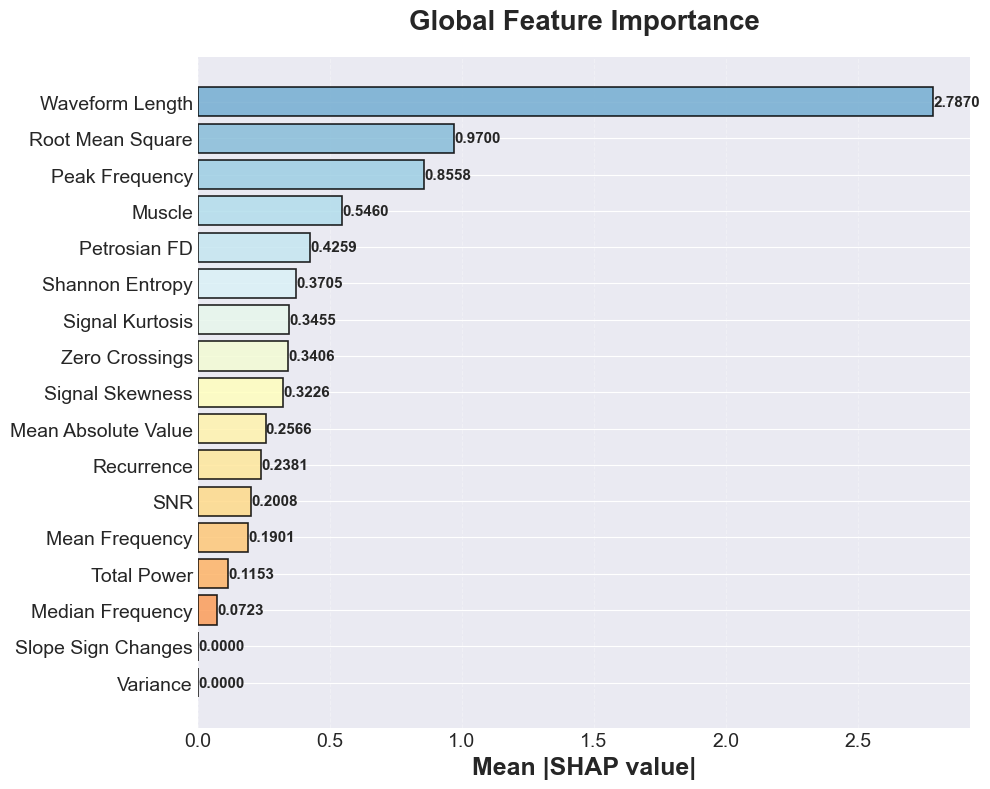

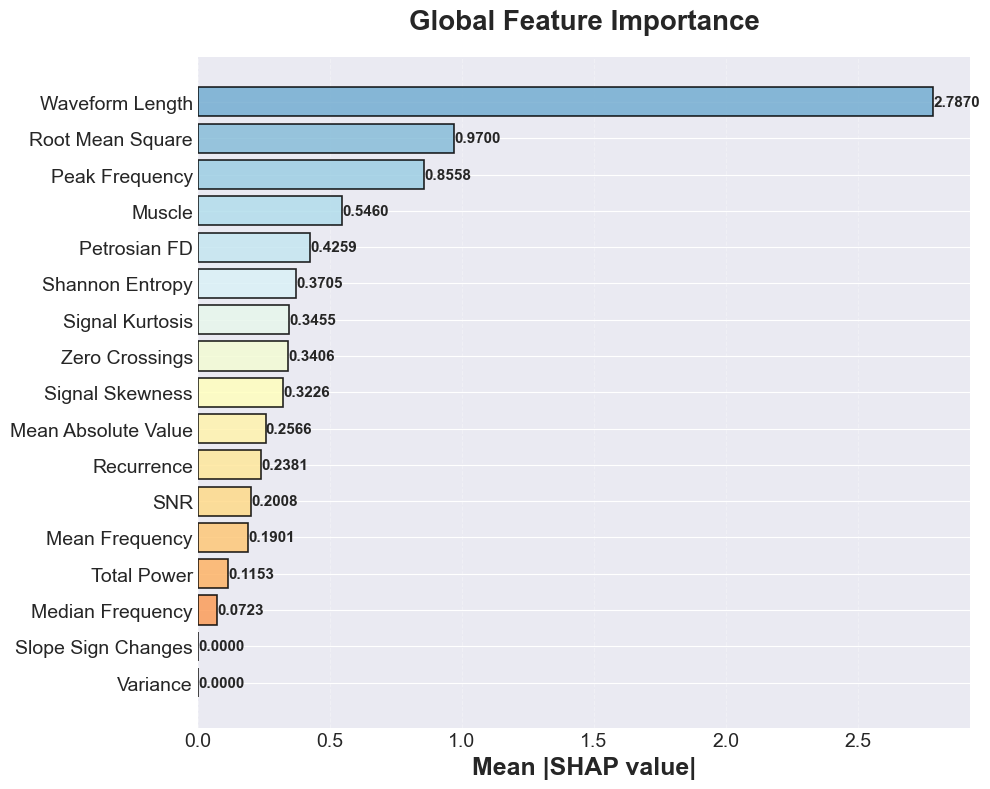

In [30]:
# Initialize SHAP analyzer with output directory
shap_analyzer = SHAPAnalyzer(
    model=classifier.best_model,
    X_test=X_test,
    feature_names=feature_names,
    threshold=classifier.threshold,
    output_dir=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Plots'
)

# Plot and save feature importance
shap_analyzer.plot_feature_importance(max_display=17, save=True, format='pdf')

# SHIFE

In [ ]:
import numpy as np
import csv

# SHAP ordered features (from most important to least important to remove)
shap_ordered_features = [
    'Variance', 
    'Slope Sign Changes', 
    'Median Frequency', 
    'Total Power', 
    'Recurrence', 
    'Signal Skewness', 
    'Zero Crossings', 
    'Petrosian FD', 
    'SNR', 
    'Mean Absolute Value', 
    'Signal Kurtosis', 
    'Shannon Entropy', 
    'Mean Frequency', 
    'Peak Frequency', 
    'Muscle', 
    'Root Mean Square'
]

custom_threshold = 0.5

# Define initial parameter grid for grid search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.3, 0.4],
    'num_leaves': [15],
    'max_depth': [5, 7],
    'min_data_in_leaf': [10],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [5]
}

def evaluate_feature_combination(selected_features, param_grid, data_path):
    """
    Valuta una combinazione di features con grid search e 100 random seeds.
    """
    print(f"\nValutazione combinazione con {len(selected_features)} features...")
    print(f"Features utilizzate: {selected_features}")
    
    # Load and prepare dataset per grid search iniziale
    preparer = EMGDatasetPreparer(data_path)
    X_train, X_test, y_train, y_test = preparer.prepare_dataset(
        feature_names=list(selected_features),
        muscle_filter='Both',
        test_size=0.2,
        balance_muscles=True,
        random_seed=42
    )
    
    # Grid search
    classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)
    best_params, all_results = classifier.grid_search(X_train, y_train, param_grid)
    
    print(f"Best params: {best_params}")
    
    # Crea param_grid con solo i migliori parametri
    best_param_grid = {
        'learning_rate': [best_params['learning_rate']],
        'num_leaves': [best_params['num_leaves']],
        'max_depth': [best_params['max_depth']],
        'min_data_in_leaf': [best_params['min_data_in_leaf']],
        'feature_fraction': [best_params['feature_fraction']],
        'bagging_fraction': [best_params['bagging_fraction']],
        'bagging_freq': [best_params['bagging_freq']]
    }
    
    # Test con 100 random seeds
    accuracy_list = []
    sensitivity_list = []
    specificity_list = []
    f1_list = []
    AUC_list = []
    MCC_list = []
    
    print("Testing con 100 random seeds...")
    for rs in range(1, 101):
        if rs % 10 == 0:
            print(f"  Progress: {rs}/100")
        
        preparer = EMGDatasetPreparer(data_path)
        X_train, X_test, y_train, y_test = preparer.prepare_dataset(
            feature_names=list(selected_features),
            muscle_filter='Both',
            test_size=0.2,
            balance_muscles=True,
            random_seed=rs
        )
        
        classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)
        _, _ = classifier.grid_search(X_train, y_train, best_param_grid)
        classifier.train_final_model(X_train, y_train)
        test_results = classifier.evaluate_test_set(X_test, y_test)
        
        accuracy_list.append(test_results['accuracy'])
        sensitivity_list.append(test_results['sensitivity'])
        specificity_list.append(test_results['specificity'])
        f1_list.append(test_results['f1'])
        AUC_list.append(test_results['auc'])
        MCC_list.append(test_results['mcc'])
    
    metrics = {
        'accuracy_mean': np.mean(accuracy_list),
        'accuracy_std': np.std(accuracy_list),
        'sensitivity_mean': np.mean(sensitivity_list),
        'sensitivity_std': np.std(sensitivity_list),
        'specificity_mean': np.mean(specificity_list),
        'specificity_std': np.std(specificity_list),
        'f1_mean': np.mean(f1_list),
        'f1_std': np.std(f1_list),
        'auc_mean': np.mean(AUC_list),
        'auc_std': np.std(AUC_list),
        'mcc_mean': np.mean(MCC_list),
        'mcc_std': np.std(MCC_list),
        'features': selected_features,
        'params': best_params
    }
    
    print(f"Accuracy: {metrics['accuracy_mean']:.5f} ± {metrics['accuracy_std']:.5f}")
    print(f"AUC: {metrics['auc_mean']:.5f} ± {metrics['auc_std']:.5f}")
    
    return metrics

def write_results_to_csv(csv_path, metrics_list, all_feature_names):
    """
    Scrive i risultati nel file CSV.
    """
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Header
        header = ['N Features', 'Accuracy Mean', 'Accuracy Std Dev', 
                  'Sensitivity Mean', 'Sensitivity Std Dev',
                  'Specificity Mean', 'Specificity Std Dev',
                  'f1 Mean', 'f1 Std Dev',
                  'AUC Mean', 'AUC Std Dev',
                  'MCC Mean', 'MCC Std Dev']
        
        # Aggiungi nomi features
        header.extend(all_feature_names)
        
        # Aggiungi parametri
        header.extend(['learning_rate', 'num_leaves', 'max_depth', 
                      'min_data_in_leaf', 'feature_fraction', 
                      'bagging_fraction', 'bagging_freq'])
        
        writer.writerow(header)
        
        # Scrivi ogni riga di risultati
        for metrics in metrics_list:
            row = [
                len(metrics['features']),
                metrics['accuracy_mean'],
                metrics['accuracy_std'],
                metrics['sensitivity_mean'],
                metrics['sensitivity_std'],
                metrics['specificity_mean'],
                metrics['specificity_std'],
                metrics['f1_mean'],
                metrics['f1_std'],
                metrics['auc_mean'],
                metrics['auc_std'],
                metrics['mcc_mean'],
                metrics['mcc_std']
            ]
            
            # Aggiungi Yes/No per ogni feature
            for feat in all_feature_names:
                row.append('Yes' if feat in metrics['features'] else 'No')
            
            # Aggiungi parametri
            params = metrics['params']
            row.extend([
                params['learning_rate'],
                params['num_leaves'],
                params['max_depth'],
                params['min_data_in_leaf'],
                params['feature_fraction'],
                params['bagging_fraction'],
                params['bagging_freq']
            ])
            
            writer.writerow(row)

if __name__ == "__main__":
    
    data_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\features_dataset_healthy_vs_neuropathy_8_20_2000_3.csv'
    output_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\shap_selection.csv'
    
    metrics_list = []
    current_features = feature_names.copy()
    
    # Iterate progressively removing features according to SHAP order
    for idx, feature_to_remove in enumerate(shap_ordered_features):
        print(f"\n{'='*80}")
        print(f"ITERAZIONE {idx + 1}/{len(shap_ordered_features)}")
        print(f"Rimozione feature: {feature_to_remove}")
        print(f"Features rimanenti: {len(current_features)}")
        print(f"{'='*80}")
        
        # Evaluate current combination
        metrics = evaluate_feature_combination(current_features, param_grid, data_path)
        metrics_list.append(metrics)
        
        print(f"\n{'='*80}")
        print(f"RESULTS WITH {len(current_features)} FEATURES:")
        print(f"Features: {current_features}")
        print(f"Accuracy: {metrics['accuracy_mean']:.5f} ± {metrics['accuracy_std']:.5f}")
        print(f"AUC: {metrics['auc_mean']:.5f} ± {metrics['auc_std']:.5f}")
        print(f"Sensitivity: {metrics['sensitivity_mean']:.5f} ± {metrics['sensitivity_std']:.5f}")
        print(f"Specificity: {metrics['specificity_mean']:.5f} ± {metrics['specificity_std']:.5f}")
        print(f"{'='*80}")
        
        # Remove the feature for the next iteration
        if feature_to_remove in current_features:
            current_features.remove(feature_to_remove)
    
    # Write results in the CSV
    print(f"\nWriting results in {output_path}...")
    write_results_to_csv(output_path, metrics_list, feature_names)
    print("COMPLETED!")
    print(f"\nResults saved in: {output_path}")
    print(f"Total number of iterations: {len(metrics_list)}")


ITERAZIONE 1/16
Rimozione feature: Variance
Features rimanenti: 17

Valutazione combinazione con 17 features...
Features utilizzate: ['Mean Absolute Value', 'Root Mean Square', 'Zero Crossings', 'Peak Frequency', 'Mean Frequency', 'Median Frequency', 'Total Power', 'Variance', 'Shannon Entropy', 'Signal Skewness', 'Signal Kurtosis', 'Petrosian FD', 'Slope Sign Changes', 'Waveform Length', 'SNR', 'Recurrence', 'Muscle']
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'seed': 42, 'learning_rate': 0.4, 'num_leaves': 15, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'bagging_freq': 5}
Testing con 100 random seeds...
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100
Accuracy: 0.91700 ± 0.03822
AUC: 0.95937 ± 0.02826

RISULTATI CON 17 FEATURES:
Features: ['Mean Absolute Value', 'Root Me

# IFE

In [147]:
import numpy as np
import csv
from itertools import combinations

# Configuration
feature_names = [
    'Mean Absolute Value',           # 0
    'Root Mean Square',              # 1
    'Zero Crossings',                # 2
    'Peak Frequency',                # 3
    'Mean Frequency',                # 4
    'Median Frequency',              # 5
    'Total Power',                   # 6
    'Variance',                      # 7
    'Shannon Entropy',               # 8
    'Signal Skewness',               # 9
    'Signal Kurtosis',               # 10
    'Petrosian FD',                  # 11
    'Slope Sign Changes',            # 12
    'Waveform Length',               # 13
    'SNR',                           # 14
    'Recurrence',                    # 15
    'Muscle'                         # 16  
]

custom_threshold = 0.5

# Define initial parameter grid for grid search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.3, 0.4],
    'num_leaves': [15],
    'max_depth': [5, 7],
    'min_data_in_leaf': [10],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [5]
}

def compare_combinations(old_metrics, new_metrics):
    """
    Compara due combinazioni secondo i criteri specificati.
    Ritorna True se new_metrics è migliore, False altrimenti.
    """
    # 1. Accuracy media
    if new_metrics['accuracy_mean'] > old_metrics['accuracy_mean']:
        return True
    elif new_metrics['accuracy_mean'] < old_metrics['accuracy_mean']:
        return False
    
    # 2. Accuracy std dev (più piccola è meglio)
    if new_metrics['accuracy_std'] < old_metrics['accuracy_std']:
        return True
    elif new_metrics['accuracy_std'] > old_metrics['accuracy_std']:
        return False
    
    # 3. AUC media
    if new_metrics['auc_mean'] > old_metrics['auc_mean']:
        return True
    elif new_metrics['auc_mean'] < old_metrics['auc_mean']:
        return False
    
    # 4. AUC std dev (più piccola è meglio)
    if new_metrics['auc_std'] < old_metrics['auc_std']:
        return True
    elif new_metrics['auc_std'] > old_metrics['auc_std']:
        return False
    
    # 5. Sensitivity media
    if new_metrics['sensitivity_mean'] > old_metrics['sensitivity_mean']:
        return True
    elif new_metrics['sensitivity_mean'] < old_metrics['sensitivity_mean']:
        return False
    
    # 6. Sensitivity std dev (più piccola è meglio)
    if new_metrics['sensitivity_std'] < old_metrics['sensitivity_std']:
        return True
    elif new_metrics['sensitivity_std'] > old_metrics['sensitivity_std']:
        return False
    
    # Tutte uguali: mantieni la vecchia
    return False

def evaluate_feature_combination(selected_features, param_grid, data_path):
    """
    Valuta una combinazione di features con grid search e 100 random seeds.
    """
    print(f"\nValutazione combinazione con {len(selected_features)} features...")
    
    # Load and prepare dataset per grid search iniziale
    preparer = EMGDatasetPreparer(data_path)
    X_train, X_test, y_train, y_test = preparer.prepare_dataset(
        feature_names=list(selected_features),
        muscle_filter='Both',
        test_size=0.2,
        balance_muscles=True,
        random_seed=42
    )
    
    # Grid search
    classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)
    best_params, all_results = classifier.grid_search(X_train, y_train, param_grid)
    
    print(f"Best params: {best_params}")
    
    # Crea param_grid con solo i migliori parametri
    best_param_grid = {
        'learning_rate': [best_params['learning_rate']],
        'num_leaves': [best_params['num_leaves']],
        'max_depth': [best_params['max_depth']],
        'min_data_in_leaf': [best_params['min_data_in_leaf']],
        'feature_fraction': [best_params['feature_fraction']],
        'bagging_fraction': [best_params['bagging_fraction']],
        'bagging_freq': [best_params['bagging_freq']]
    }
    
    # Test con 100 random seeds
    accuracy_list = []
    sensitivity_list = []
    specificity_list = []
    f1_list = []
    AUC_list = []
    MCC_list = []
    
    print("Testing con 100 random seeds...")
    for rs in range(1, 101):
        if rs % 10 == 0:
            print(f"  Progress: {rs}/100")
        
        preparer = EMGDatasetPreparer(data_path)
        X_train, X_test, y_train, y_test = preparer.prepare_dataset(
            feature_names=list(selected_features),
            muscle_filter='Both',
            test_size=0.2,
            balance_muscles=True,
            random_seed=rs
        )
        
        classifier = LGBMClassifierCV(n_folds=5, random_seed=42, threshold=custom_threshold)
        _, _ = classifier.grid_search(X_train, y_train, best_param_grid)
        classifier.train_final_model(X_train, y_train)
        test_results = classifier.evaluate_test_set(X_test, y_test)
        
        accuracy_list.append(test_results['accuracy'])
        sensitivity_list.append(test_results['sensitivity'])
        specificity_list.append(test_results['specificity'])
        f1_list.append(test_results['f1'])
        AUC_list.append(test_results['auc'])
        MCC_list.append(test_results['mcc'])
    
    metrics = {
        'accuracy_mean': np.mean(accuracy_list),
        'accuracy_std': np.std(accuracy_list),
        'sensitivity_mean': np.mean(sensitivity_list),
        'sensitivity_std': np.std(sensitivity_list),
        'specificity_mean': np.mean(specificity_list),
        'specificity_std': np.std(specificity_list),
        'f1_mean': np.mean(f1_list),
        'f1_std': np.std(f1_list),
        'auc_mean': np.mean(AUC_list),
        'auc_std': np.std(AUC_list),
        'mcc_mean': np.mean(MCC_list),
        'mcc_std': np.std(MCC_list),
        'features': selected_features,
        'params': best_params
    }
    
    print(f"Accuracy: {metrics['accuracy_mean']:.5f} ± {metrics['accuracy_std']:.5f}")
    
    return metrics

def write_results_to_csv(csv_path, best_metrics_list, all_feature_names):
    """
    Scrive i risultati nel file CSV.
    """
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Header
        header = ['N Features', 'Accuracy Mean', 'Accuracy Std Dev', 
                  'Sensitivity Mean', 'Sensitivity Std Dev',
                  'Specificity Mean', 'Specificity Std Dev',
                  'f1 Mean', 'f1 Std Dev',
                  'AUC Mean', 'AUC Std Dev',
                  'MCC Mean', 'MCC Std Dev']
        
        # Aggiungi nomi features
        header.extend(all_feature_names)
        
        # Aggiungi parametri
        header.extend(['learning_rate', 'num_leaves', 'max_depth', 
                      'min_data_in_leaf', 'feature_fraction', 
                      'bagging_fraction', 'bagging_freq'])
        
        writer.writerow(header)
        
        # Scrivi ogni riga di risultati
        for metrics in best_metrics_list:
            row = [
                len(metrics['features']),
                metrics['accuracy_mean'],
                metrics['accuracy_std'],
                metrics['sensitivity_mean'],
                metrics['sensitivity_std'],
                metrics['specificity_mean'],
                metrics['specificity_std'],
                metrics['f1_mean'],
                metrics['f1_std'],
                metrics['auc_mean'],
                metrics['auc_std'],
                metrics['mcc_mean'],
                metrics['mcc_std']
            ]
            
            # Aggiungi Yes/No per ogni feature
            for feat in all_feature_names:
                row.append('Yes' if feat in metrics['features'] else 'No')
            
            # Aggiungi parametri
            params = metrics['params']
            row.extend([
                params['learning_rate'],
                params['num_leaves'],
                params['max_depth'],
                params['min_data_in_leaf'],
                params['feature_fraction'],
                params['bagging_fraction'],
                params['bagging_freq']
            ])
            
            writer.writerow(row)

if __name__ == "__main__":
    
    data_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\features_dataset_healthy_vs_neuropathy_8_20_2000_3.csv'
    output_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\ricerca_sensata.csv'
    
    best_metrics_list = []
    current_features = feature_names.copy()
    
    # Itera da 16 features a 1 feature
    for n_features in range(len(feature_names) - 1, 0, -1):
        print(f"\n{'='*80}")
        print(f"RICERCA MIGLIORE COMBINAZIONE DI {n_features} FEATURES")
        print(f"{'='*80}")
        
        # Genera tutte le combinazioni
        all_combinations = list(combinations(current_features, n_features))
        print(f"Numero totale di combinazioni: {len(all_combinations)}")
        
        best_metrics = None
        
        # Valuta ogni combinazione
        for idx, combo in enumerate(all_combinations, 1):
            print(f"\n--- Combinazione {idx}/{len(all_combinations)} ---")
            print(f"Features: {combo}")
            
            metrics = evaluate_feature_combination(combo, param_grid, data_path)
            
            # Confronta con la migliore fino ad ora
            if best_metrics is None or compare_combinations(best_metrics, metrics):
                best_metrics = metrics
                print("*** NUOVA MIGLIORE COMBINAZIONE! ***")
        
        # Salva la migliore combinazione
        best_metrics_list.append(best_metrics)
        print(f"\n{'='*80}")
        print(f"MIGLIORE COMBINAZIONE CON {n_features} FEATURES:")
        print(f"Features: {best_metrics['features']}")
        print(f"Accuracy: {best_metrics['accuracy_mean']:.5f} ± {best_metrics['accuracy_std']:.5f}")
        print(f"AUC: {best_metrics['auc_mean']:.5f} ± {best_metrics['auc_std']:.5f}")
        print(f"{'='*80}")
        
        # Aggiorna current_features per la prossima iterazione
        current_features = list(best_metrics['features'])
    
    # Scrivi i risultati nel CSV
    print(f"\nScrittura risultati in {output_path}...")
    write_results_to_csv(output_path, best_metrics_list, feature_names)
    print("COMPLETATO!")


RICERCA MIGLIORE COMBINAZIONE DI 16 FEATURES
Numero totale di combinazioni: 17

--- Combinazione 1/17 ---
Features: ('Mean Absolute Value', 'Root Mean Square', 'Zero Crossings', 'Peak Frequency', 'Mean Frequency', 'Median Frequency', 'Total Power', 'Variance', 'Shannon Entropy', 'Signal Skewness', 'Signal Kurtosis', 'Petrosian FD', 'Slope Sign Changes', 'Waveform Length', 'SNR', 'Recurrence')

Valutazione combinazione con 16 features...
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'seed': 42, 'learning_rate': 0.4, 'num_leaves': 15, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 5}
Testing con 100 random seeds...
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100
Accuracy: 0.90325 ± 0.04041
*** NUOVA MIGLIORE COMBINAZIONE! ***

--- Combinazione 2/17 ---
Features: (

# PLOT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

class FeatureSelectionComparator:
    """Compare different feature selection methods with modern visualizations"""
    
    def __init__(self, shap_csv: str, search_csv: str):
        """
        Initialize comparator with CSV files
        
        Args:
            shap_csv: Path to SHAP-based feature selection results
            search_csv: Path to search-based feature selection results
        """
        self.shap_df = pd.read_csv(shap_csv)
        self.search_df = pd.read_csv(search_csv)
        
        # Ensure data is sorted by number of features
        self.shap_df = self.shap_df.sort_values('N Features')
        self.search_df = self.search_df.sort_values('N Features')
        
        # Setup modern style
        plt.style.use('seaborn-v0_8-whitegrid')
        self.colors = {
            'SHIFE': '#FF6B6B',      # Coral red
            'IFE': '#4ECDC4'     # Turquoise
        }
        self.alpha = 0.15  # Transparency for error bands
    
    def _plot_metric_comparison(self, metric_name: str, ylabel: str, 
                                figsize: Tuple = (12, 7), ylim: Tuple = None):
        """
        Plot comparison of a metric between SHAP and search-based selection
        
        Args:
            metric_name: Base name of metric (e.g., 'Accuracy', 'Sensitivity')
            ylabel: Label for y-axis
            figsize: Figure size
            ylim: Y-axis limits (optional)
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Extract data
        n_features = self.shap_df['N Features'].values
        shap_mean = self.shap_df[f'{metric_name} Mean'].values
        shap_std = self.shap_df[f'{metric_name} Std Dev'].values
        search_mean = self.search_df[f'{metric_name} Mean'].values
        search_std = self.search_df[f'{metric_name} Std Dev'].values
        
        # Plot SHAP-based results
        ax.plot(n_features, shap_mean, marker='o', markersize=10, 
               linewidth=3, label='SHIFE',
               color=self.colors['SHIFE'], markeredgewidth=2, 
               markeredgecolor='white', zorder=3)
        ax.errorbar(n_features, shap_mean, yerr=shap_std,
                   fmt='none', elinewidth=2.5, capsize=6, capthick=2.5,
                   color=self.colors['SHIFE'], alpha=0.6, zorder=2)
        ax.fill_between(n_features, shap_mean - shap_std, shap_mean + shap_std,
                       alpha=self.alpha, color=self.colors['SHIFE'])
        
        # Plot search-based results
        ax.plot(n_features, search_mean, marker='s', markersize=10,
               linewidth=3, label='Grid Search Selection',
               color=self.colors['IFE'], markeredgewidth=2,
               markeredgecolor='white', zorder=3)
        ax.errorbar(n_features, search_mean, yerr=search_std,
                   fmt='none', elinewidth=2.5, capsize=6, capthick=2.5,
                   color=self.colors['IFE'], alpha=0.6, zorder=2)
        ax.fill_between(n_features, search_mean - search_std, search_mean + search_std,
                      alpha=self.alpha, color=self.colors['IFE'])
        
        # Styling - TESTI INGRANDITI
        ax.set_xlabel('Number of Features', fontsize=18, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=18, fontweight='bold')
        ax.set_title(f'{metric_name} vs Number of Features', 
                    fontsize=20, fontweight='bold', pad=20)
        
        # Set x-axis ticks - NUMERI INGRANDITI
        ax.set_xticks(n_features)
        ax.set_xticklabels(n_features.astype(int), fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        
        # Set y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)
        
        # Legend - TESTO INGRANDITO
        ax.legend(loc='best', fontsize=15, frameon=True, shadow=True,
                 fancybox=True, framealpha=0.95)
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        plt.tight_layout()
        plt.show()
    
    def plot_all_metrics(self, figsize: Tuple = (12, 7)):
        """
        Generate all 6 comparison plots
        
        Args:
            figsize: Figure size for each plot
        """
        metrics = [
            ('Accuracy', 'Mean Accuracy', (0.75, 1.0)),
            ('Sensitivity', 'Mean Sensitivity (Recall)', (0.75, 1.0)),
            ('Specificity', 'Mean Specificity', (0.75, 1.0)),
            ('AUC', 'Mean AUC (ROC)', (0.8, 1.0))
        ]
        
        for metric_name, ylabel, ylim in metrics:
            print(f"\nPlotting {metric_name}...")
            self._plot_metric_comparison(metric_name, ylabel, figsize, ylim)
    
    def plot_summary_comparison(self, figsize: Tuple = (14, 10)):
        """
        Plot summary comparison with 4 metrics in a 2x2 grid:
        Accuracy | AUC
        Sensitivity | Specificity
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()

        metrics = [
            ('Accuracy', 'Accuracy', (0.75, 1.0)),
            ('AUC', 'AUC', (0.8, 1.0)),
            ('Sensitivity', 'Sensitivity', (0.75, 1.0)),
            ('Specificity', 'Specificity', (0.75, 1.0))
        ]

        n_features = self.shap_df['N Features'].values

        for idx, (metric_name, ylabel, ylim) in enumerate(metrics):
            ax = axes[idx]

            shap_mean = self.shap_df[f'{metric_name} Mean'].values
            shap_std = self.shap_df[f'{metric_name} Std Dev'].values
            search_mean = self.search_df[f'{metric_name} Mean'].values
            search_std = self.search_df[f'{metric_name} Std Dev'].values

            # SHAP
            ax.plot(n_features, shap_mean, marker='o', markersize=8,
                    linewidth=2.5, label='SHIFE',
                    color=self.colors['SHIFE'], markeredgewidth=1.5,
                    markeredgecolor='white', zorder=3)
            ax.errorbar(n_features, shap_mean, yerr=shap_std,
                        fmt='none', elinewidth=2, capsize=5, capthick=2,
                        color=self.colors['SHIFE'], alpha=0.6, zorder=2)
            ax.fill_between(n_features, shap_mean - shap_std, shap_mean + shap_std,
                            alpha=self.alpha, color=self.colors['SHIFE'])

            # SEARCH
            ax.plot(n_features, search_mean, marker='s', markersize=8,
                    linewidth=2.5, label='IFE',
                    color=self.colors['IFE'], markeredgewidth=1.5,
                    markeredgecolor='white', zorder=3)
            ax.errorbar(n_features, search_mean, yerr=search_std,
                        fmt='none', elinewidth=2, capsize=5, capthick=2,
                        color=self.colors['IFE'], alpha=0.6, zorder=2)
            ax.fill_between(n_features, search_mean - search_std,
                            search_mean + search_std,
                            alpha=self.alpha, color=self.colors['IFE'])

            # TESTI INGRANDITI
            ax.set_xlabel('N Features', fontsize=14, fontweight='bold')
            ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
            ax.set_title(f'{metric_name}', fontsize=16, fontweight='bold', pad=10)

            # NUMERI SUGLI ASSI INGRANDITI
            ax.set_xticks(n_features)
            ax.set_xticklabels(n_features.astype(int), fontsize=12)
            ax.tick_params(axis='y', labelsize=12)

            if ylim is not None:
                ax.set_ylim(ylim)

            if idx == 0:
                ax.legend(loc='lower right', fontsize=13, frameon=True,
                        shadow=True, fancybox=True, framealpha=0.95)

            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.6)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # TITOLO PRINCIPALE INGRANDITO
        plt.suptitle('Feature Selection Methods Comparison',
                    fontsize=22, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

    
    def print_best_configurations(self):
        """Print best configuration for each method"""
        print("\n" + "="*70)
        print("BEST CONFIGURATIONS")
        print("="*70)
        
        # Find best for SHAP (highest AUC)
        shap_best_idx = self.shap_df['AUC Mean'].idxmax()
        shap_best = self.shap_df.loc[shap_best_idx]
        
        print("\nSHAP-based Selection:")
        print(f"  N Features: {int(shap_best['N Features'])}")
        print(f"  Accuracy: {shap_best['Accuracy Mean']:.4f} ± {shap_best['Accuracy Std Dev']:.4f}")
        print(f"  Sensitivity: {shap_best['Sensitivity Mean']:.4f} ± {shap_best['Sensitivity Std Dev']:.4f}")
        print(f"  Specificity: {shap_best['Specificity Mean']:.4f} ± {shap_best['Specificity Std Dev']:.4f}")
        print(f"  AUC: {shap_best['AUC Mean']:.4f} ± {shap_best['AUC Std Dev']:.4f}")

        
        # Find best for Search
        search_best_idx = self.search_df['AUC Mean'].idxmax()
        search_best = self.search_df.loc[search_best_idx]
        
        print("\nGrid Search Selection:")
        print(f"  N Features: {int(search_best['N Features'])}")
        print(f"  Accuracy: {search_best['Accuracy Mean']:.4f} ± {search_best['Accuracy Std Dev']:.4f}")
        print(f"  Sensitivity: {search_best['Sensitivity Mean']:.4f} ± {search_best['Sensitivity Std Dev']:.4f}")
        print(f"  Specificity: {search_best['Specificity Mean']:.4f} ± {search_best['Specificity Std Dev']:.4f}")
        print(f"  AUC: {search_best['AUC Mean']:.4f} ± {search_best['AUC Std Dev']:.4f}")
        print("\n" + "="*70)


Plotting Accuracy...


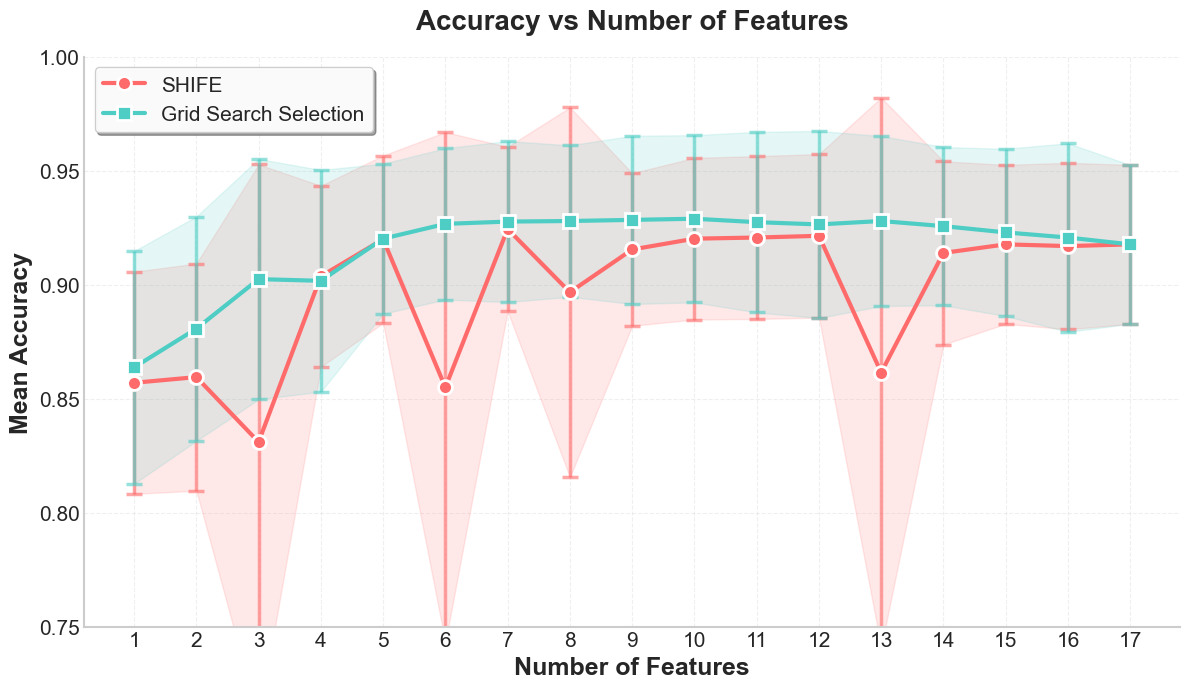


Plotting Sensitivity...


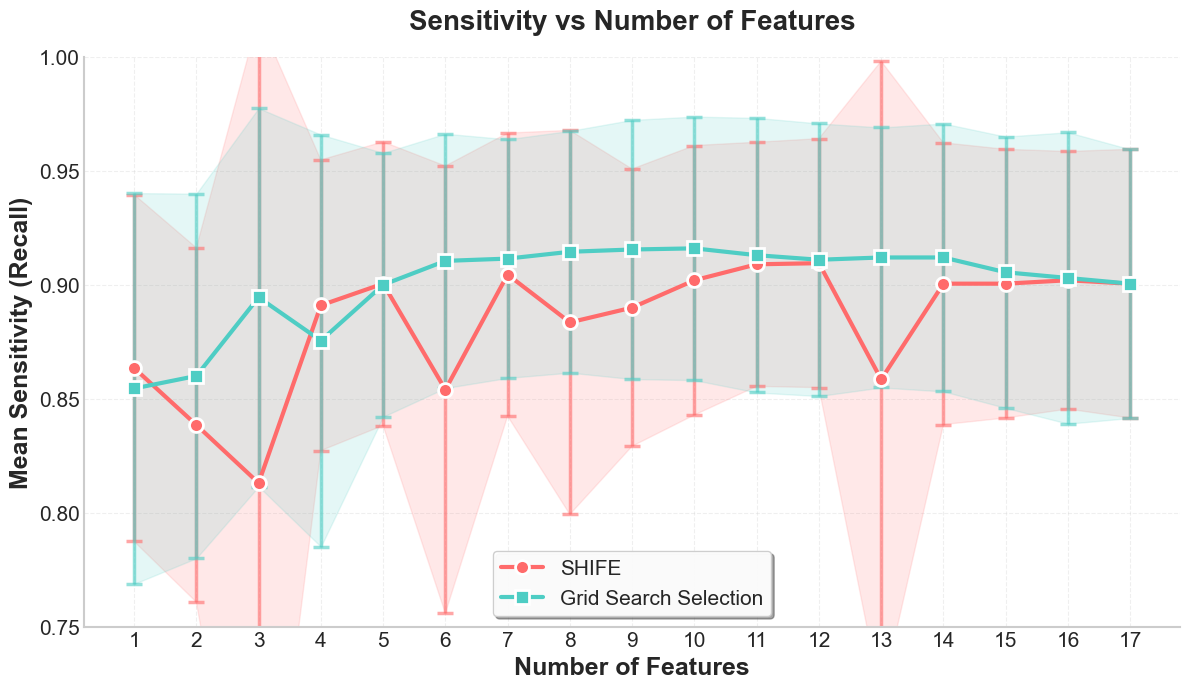


Plotting Specificity...


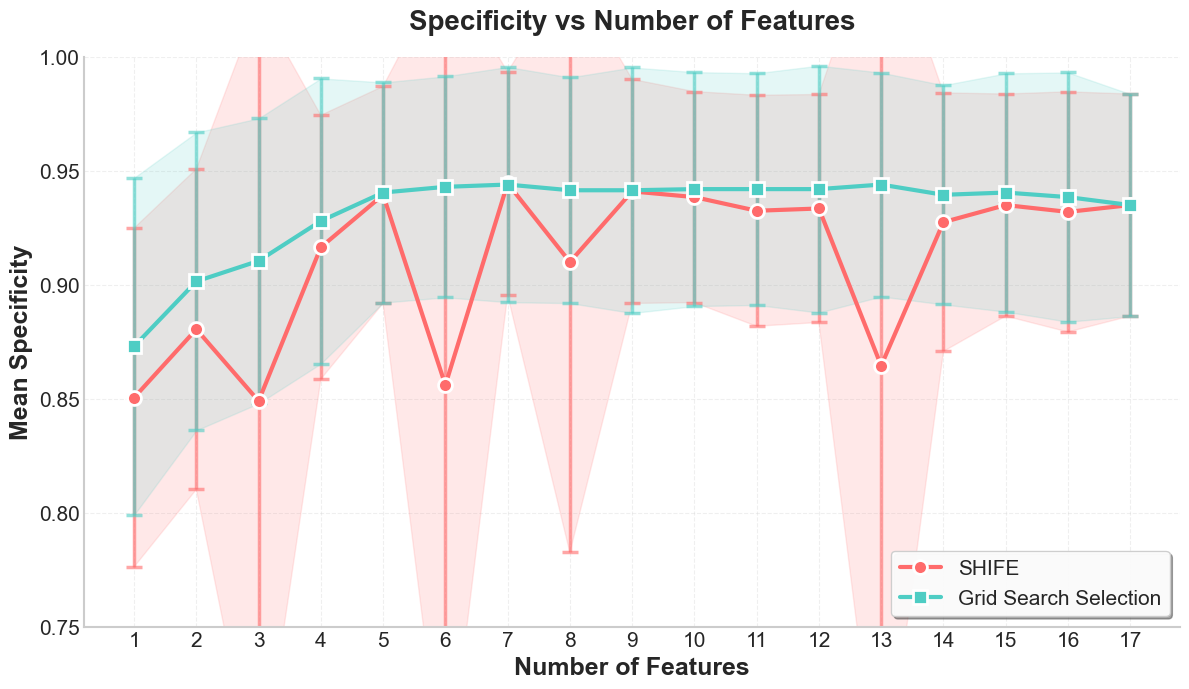


Plotting AUC...


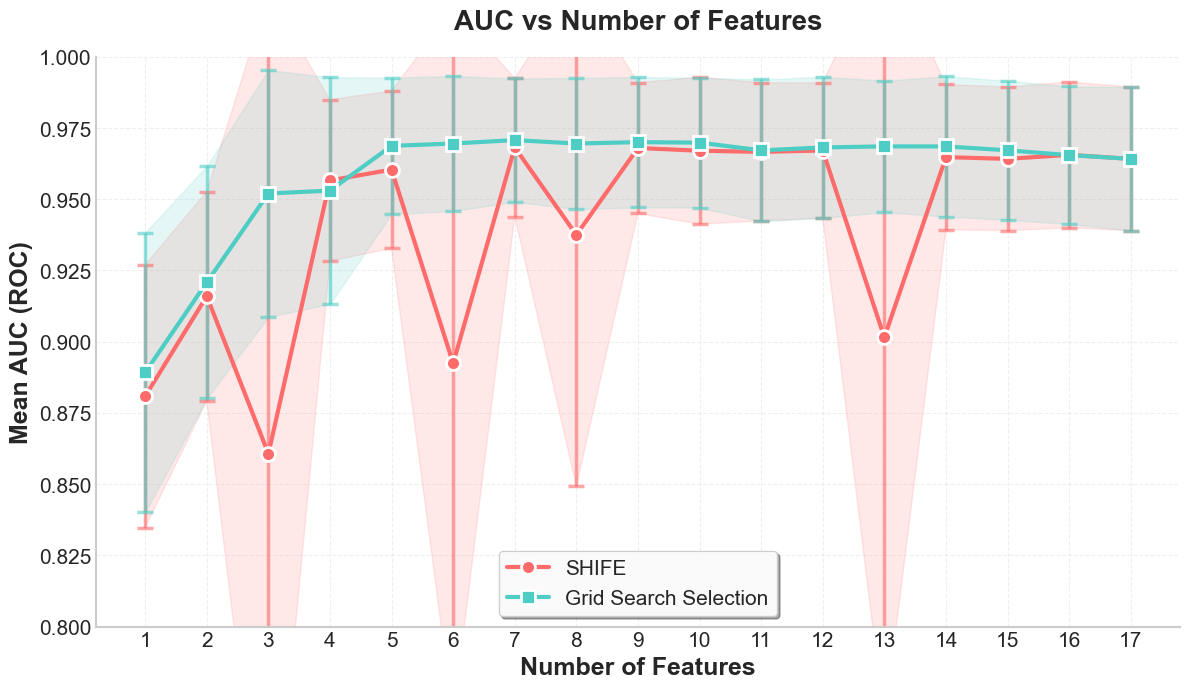

In [2]:

# Example usage:

# Initialize comparator
comparator = FeatureSelectionComparator(
    shap_csv=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\shap_final_selection.csv',
    search_csv=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\search_final_selection.csv'
)

# Option 1: Plot all metrics separately (6 individual plots)
comparator.plot_all_metrics(figsize=(12, 7))



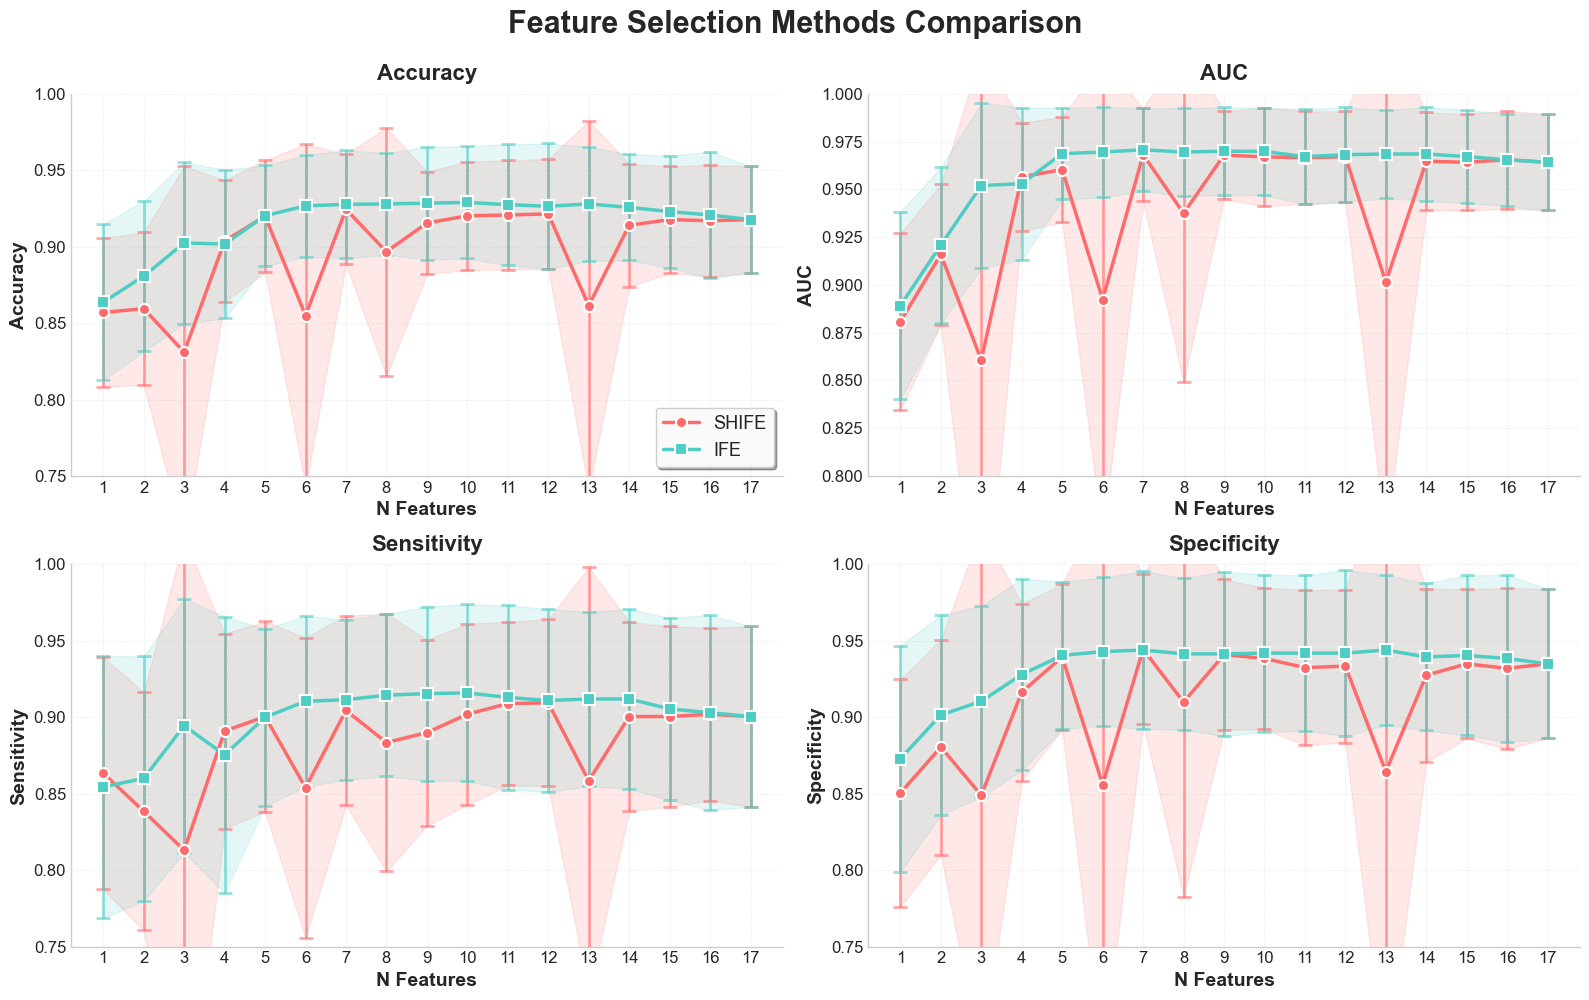

In [3]:
# Option 2: Plot all metrics in a single figure (2x3 grid)
comparator.plot_summary_comparison(figsize=(16, 10))



In [69]:
# Print best configurations
comparator.print_best_configurations()


BEST CONFIGURATIONS

SHAP-based Selection:
  N Features: 7
  Accuracy: 0.9245 ± 0.0360
  Sensitivity: 0.9045 ± 0.0621
  Specificity: 0.9445 ± 0.0489
  AUC: 0.9682 ± 0.0243

Grid Search Selection:
  N Features: 7
  Accuracy: 0.9277 ± 0.0353
  Sensitivity: 0.9115 ± 0.0524
  Specificity: 0.9440 ± 0.0516
  AUC: 0.9708 ± 0.0216



# PLOT 2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional
import os

class FeatureSelectionComparator:
    """Compare different feature selection methods with modern visualizations"""
    
    def __init__(self, shap_csv: str, search_csv: str, output_dir: Optional[str] = None):
        """
        Initialize comparator with CSV files
        
        Args:
            shap_csv: Path to SHAP-based feature selection results
            search_csv: Path to search-based feature selection results
            output_dir: Directory to save plots (optional, defaults to current directory)
        """
        self.shap_df = pd.read_csv(shap_csv)
        self.search_df = pd.read_csv(search_csv)
        
        # Setup output directory
        self.output_dir = output_dir if output_dir else os.getcwd()
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        # Ensure data is sorted by number of features
        self.shap_df = self.shap_df.sort_values('N Features')
        self.search_df = self.search_df.sort_values('N Features')
        
        # Setup modern style
        plt.style.use('seaborn-v0_8-whitegrid')
        self.colors = {
            'SHIFE': '#FF6B6B',      # Coral red
            'IFE': '#4ECDC4'     # Turquoise
        }
        self.alpha = 0.15  # Transparency for error bands
    
    def _plot_metric_comparison(self, metric_name: str, ylabel: str, 
                                figsize: Tuple = (12, 7), ylim: Tuple = None,
                                save: bool = False, format: str = 'pdf'):
        """
        Plot comparison of a metric between SHAP and search-based selection
        
        Args:
            metric_name: Base name of metric (e.g., 'Accuracy', 'Sensitivity')
            ylabel: Label for y-axis
            figsize: Figure size
            ylim: Y-axis limits (optional)
            save: Whether to save the figure
            format: File format ('pdf', 'svg', 'eps', or 'png')
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Extract data
        n_features = self.shap_df['N Features'].values
        shap_mean = self.shap_df[f'{metric_name} Mean'].values
        shap_std = self.shap_df[f'{metric_name} Std Dev'].values
        search_mean = self.search_df[f'{metric_name} Mean'].values
        search_std = self.search_df[f'{metric_name} Std Dev'].values
        
        # Plot SHAP-based results
        ax.plot(n_features, shap_mean, marker='o', markersize=10, 
               linewidth=3, label='SHIFE',
               color=self.colors['SHIFE'], markeredgewidth=2, 
               markeredgecolor='white', zorder=3)
        ax.errorbar(n_features, shap_mean, yerr=shap_std,
                   fmt='none', elinewidth=2.5, capsize=6, capthick=2.5,
                   color=self.colors['SHIFE'], alpha=0.6, zorder=2)
        ax.fill_between(n_features, shap_mean - shap_std, shap_mean + shap_std,
                       alpha=self.alpha, color=self.colors['SHIFE'])
        
        # Plot search-based results
        ax.plot(n_features, search_mean, marker='s', markersize=10,
               linewidth=3, label='Grid Search Selection',
               color=self.colors['IFE'], markeredgewidth=2,
               markeredgecolor='white', zorder=3)
        ax.errorbar(n_features, search_mean, yerr=search_std,
                   fmt='none', elinewidth=2.5, capsize=6, capthick=2.5,
                   color=self.colors['IFE'], alpha=0.6, zorder=2)
        ax.fill_between(n_features, search_mean - search_std, search_mean + search_std,
                      alpha=self.alpha, color=self.colors['IFE'])
        
        # Styling - TESTI INGRANDITI
        ax.set_xlabel('Number of Features', fontsize=20, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=20, fontweight='bold')
        ax.set_title(f'{metric_name} vs Number of Features', 
                    fontsize=22, fontweight='bold', pad=20)
        
        # Set x-axis ticks - NUMERI INGRANDITI
        ax.set_xticks(n_features)
        ax.set_xticklabels(n_features.astype(int), fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
        # Set y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)
        
        # Legend - TESTO INGRANDITO
        ax.legend(loc='best', fontsize=16, frameon=True, shadow=True,
                 fancybox=True, framealpha=0.95)
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        plt.tight_layout()
        
        # Save if requested
        if save:
            filename = os.path.join(self.output_dir, f'{metric_name}_comparison.{format}')
            plt.savefig(filename, format=format, bbox_inches='tight', dpi=300)
            print(f"Saved: {filename}")
        
        plt.show()
    
    def plot_all_metrics(self, figsize: Tuple = (12, 7), save: bool = False, format: str = 'pdf'):
        """
        Generate all 4 comparison plots
        
        Args:
            figsize: Figure size for each plot
            save: Whether to save figures
            format: File format ('pdf', 'svg', 'eps', or 'png')
        """
        metrics = [
            ('Accuracy', 'Mean Accuracy', (0.75, 1.0)),
            ('Sensitivity', 'Mean Sensitivity (Recall)', (0.75, 1.0)),
            ('Specificity', 'Mean Specificity', (0.75, 1.0)),
            ('AUC', 'Mean AUC (ROC)', (0.8, 1.0))
        ]
        
        for metric_name, ylabel, ylim in metrics:
            print(f"\nPlotting {metric_name}...")
            self._plot_metric_comparison(metric_name, ylabel, figsize, ylim, save, format)
    
    def plot_summary_comparison(self, figsize: Tuple = (14, 10), save: bool = False, format: str = 'pdf'):
        """
        Plot summary comparison with 4 metrics in a 2x2 grid:
        Accuracy | AUC
        Sensitivity | Specificity
        
        Args:
            figsize: Figure size
            save: Whether to save the figure
            format: File format ('pdf', 'svg', 'eps', or 'png')
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()

        metrics = [
            ('Accuracy', 'Accuracy', (0.75, 1.0)),
            ('AUC', 'AUC', (0.8, 1.0)),
            ('Sensitivity', 'Sensitivity', (0.75, 1.0)),
            ('Specificity', 'Specificity', (0.75, 1.0))
        ]

        n_features = self.shap_df['N Features'].values

        for idx, (metric_name, ylabel, ylim) in enumerate(metrics):
            ax = axes[idx]

            shap_mean = self.shap_df[f'{metric_name} Mean'].values
            shap_std = self.shap_df[f'{metric_name} Std Dev'].values
            search_mean = self.search_df[f'{metric_name} Mean'].values
            search_std = self.search_df[f'{metric_name} Std Dev'].values

            # SHAP
            ax.plot(n_features, shap_mean, marker='o', markersize=8,
                    linewidth=2.5, label='SHIFE',
                    color=self.colors['SHIFE'], markeredgewidth=1.5,
                    markeredgecolor='white', zorder=3)
            ax.errorbar(n_features, shap_mean, yerr=shap_std,
                        fmt='none', elinewidth=2, capsize=5, capthick=2,
                        color=self.colors['SHIFE'], alpha=0.6, zorder=2)
            ax.fill_between(n_features, shap_mean - shap_std, shap_mean + shap_std,
                            alpha=self.alpha, color=self.colors['SHIFE'])

            # SEARCH
            ax.plot(n_features, search_mean, marker='s', markersize=8,
                    linewidth=2.5, label='IFE',
                    color=self.colors['IFE'], markeredgewidth=1.5,
                    markeredgecolor='white', zorder=3)
            ax.errorbar(n_features, search_mean, yerr=search_std,
                        fmt='none', elinewidth=2, capsize=5, capthick=2,
                        color=self.colors['IFE'], alpha=0.6, zorder=2)
            ax.fill_between(n_features, search_mean - search_std,
                            search_mean + search_std,
                            alpha=self.alpha, color=self.colors['IFE'])

            # TESTI INGRANDITI
            ax.set_xlabel('N Features', fontsize=15, fontweight='bold')
            ax.set_ylabel(ylabel, fontsize=15, fontweight='bold')
            ax.set_title(f'{metric_name}', fontsize=17, fontweight='bold', pad=10)

            # NUMERI SUGLI ASSI INGRANDITI
            ax.set_xticks(n_features)
            ax.set_xticklabels(n_features.astype(int), fontsize=13)
            ax.tick_params(axis='y', labelsize=13)

            if ylim is not None:
                ax.set_ylim(ylim)

            if idx == 0:
                ax.legend(loc='lower right', fontsize=14, frameon=True,
                        shadow=True, fancybox=True, framealpha=0.95)

            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.6)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # TITOLO PRINCIPALE INGRANDITO
        plt.suptitle('Feature Selection Methods Comparison',
                    fontsize=24, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save if requested
        if save:
            filename = os.path.join(self.output_dir, f'summary_comparison.{format}')
            plt.savefig(filename, format=format, bbox_inches='tight', dpi=300)
            print(f"Saved: {filename}")
        
        plt.show()

    
    def print_best_configurations(self):
        """Print best configuration for each method"""
        print("\n" + "="*70)
        print("BEST CONFIGURATIONS")
        print("="*70)
        
        # Find best for SHAP (highest AUC)
        shap_best_idx = self.shap_df['AUC Mean'].idxmax()
        shap_best = self.shap_df.loc[shap_best_idx]
        
        print("\nSHAP-based Selection:")
        print(f"  N Features: {int(shap_best['N Features'])}")
        print(f"  Accuracy: {shap_best['Accuracy Mean']:.4f} ± {shap_best['Accuracy Std Dev']:.4f}")
        print(f"  Sensitivity: {shap_best['Sensitivity Mean']:.4f} ± {shap_best['Sensitivity Std Dev']:.4f}")
        print(f"  Specificity: {shap_best['Specificity Mean']:.4f} ± {shap_best['Specificity Std Dev']:.4f}")
        print(f"  AUC: {shap_best['AUC Mean']:.4f} ± {shap_best['AUC Std Dev']:.4f}")

        
        # Find best for Search
        search_best_idx = self.search_df['AUC Mean'].idxmax()
        search_best = self.search_df.loc[search_best_idx]
        
        print("\nGrid Search Selection:")
        print(f"  N Features: {int(search_best['N Features'])}")
        print(f"  Accuracy: {search_best['Accuracy Mean']:.4f} ± {search_best['Accuracy Std Dev']:.4f}")
        print(f"  Sensitivity: {search_best['Sensitivity Mean']:.4f} ± {search_best['Sensitivity Std Dev']:.4f}")
        print(f"  Specificity: {search_best['Specificity Mean']:.4f} ± {search_best['Specificity Std Dev']:.4f}")
        print(f"  AUC: {search_best['AUC Mean']:.4f} ± {search_best['AUC Std Dev']:.4f}")
        print("\n" + "="*70)

Saved: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Plots\summary_comparison.pdf


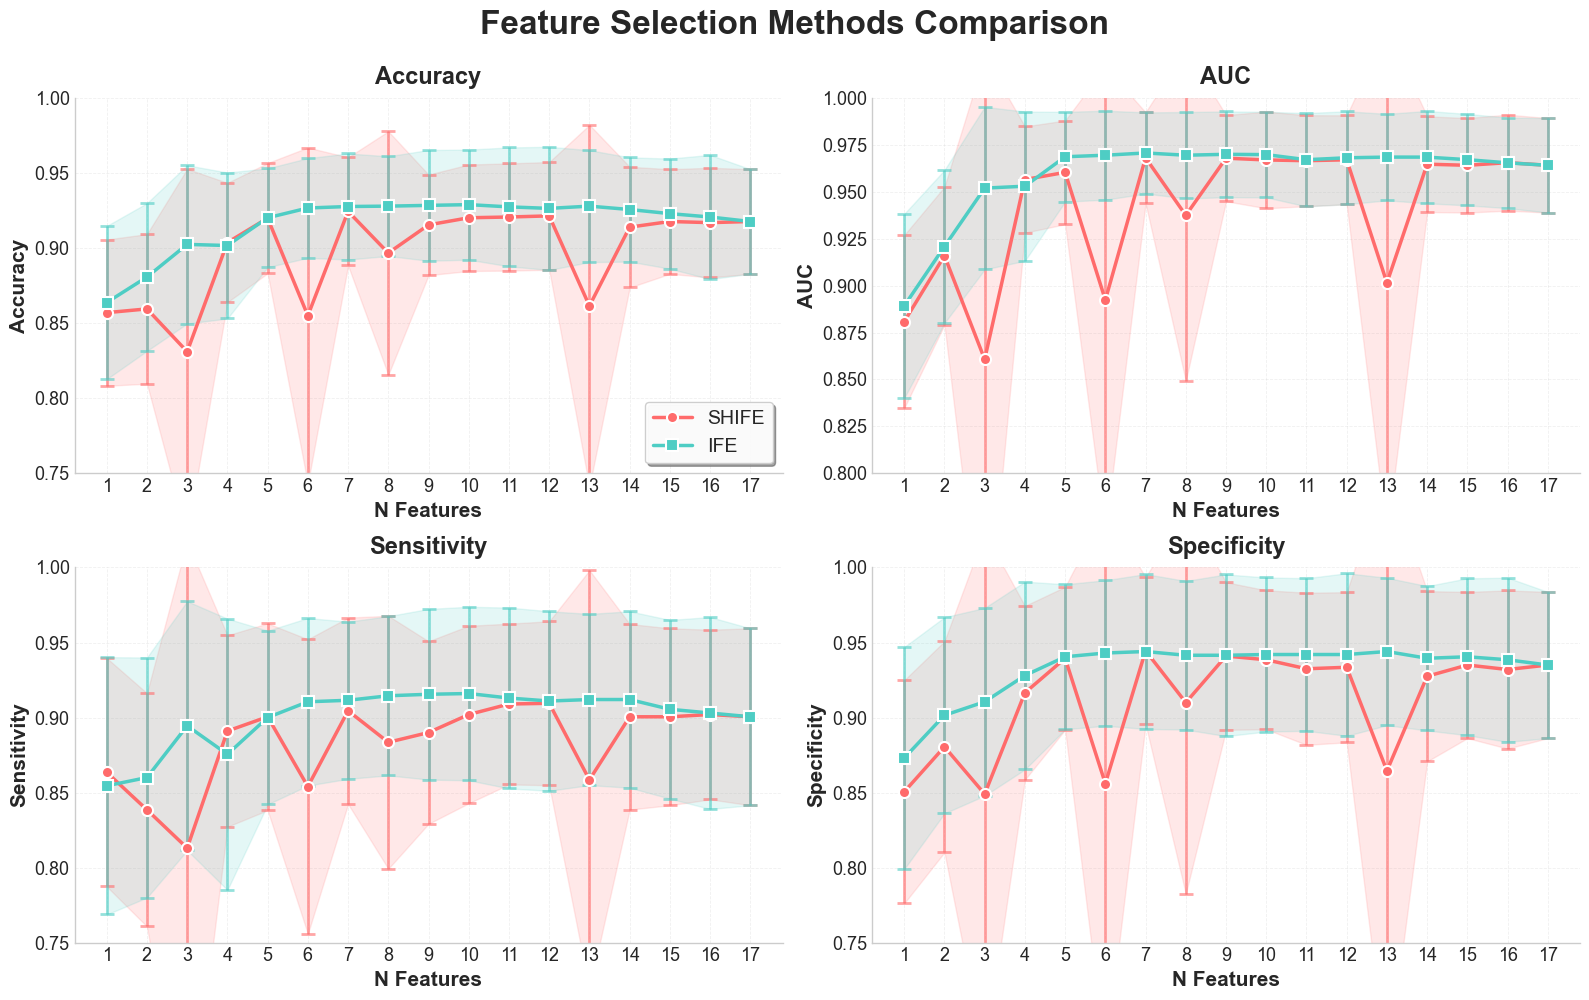

In [8]:
# Initialize with optional output directory
comparator = FeatureSelectionComparator(
    shap_csv=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\shap_final_selection.csv',
    search_csv=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\search_final_selection.csv',
    output_dir=r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Plots'  # Optional
)

# Save individual plots as PDF (recommended for publications)
# comparator.plot_all_metrics(figsize=(12, 7), save=True, format='pdf')

# Save summary plot as PDF
comparator.plot_summary_comparison(figsize=(16, 10), save=True, format='pdf')

# Or save as SVG (great for editing in Inkscape/Illustrator)
# comparator.plot_summary_comparison(figsize=(16, 10), save=True, format='svg')

# Or save as EPS (for some journals)
# comparator.plot_summary_comparison(figsize=(16, 10), save=True, format='eps')